In [186]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [187]:
def plot_througput(data, label, do_plot=True):
    """
    Throughput speed in Mbps
    """
    times = data[:,0]
    throughputs = data[:,1]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, throughputs, label="throughput "+label) 
        ax1.set_title("Throughput vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Mbps')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("throughput vs Time.png", format="png")
        fig.show()
    return np.mean(throughputs), np.percentile(throughputs, 99)

In [188]:
def plot_cwnd(data, label, do_plot=True):
    times = data[:,0]
    throughputs = data[:,1]
    cwnds = data[:,2]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    cwnds = cwnds[:throughputs.shape[0]]
    
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
    cwnds = cwnds[cwnds.shape[0] - throughputs.shape[0]:]
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, cwnds, label="cwnd "+label) 
        ax1.set_title("Cwnd vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Packets')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("cwnd vs Time.png", format="png")
        fig.show()

In [189]:
def plot_queue_size(data, label, do_plot=True):
    
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [190]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing miliseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [191]:
def print_results():
    print("Mean Q length in Kbytes {0} and in packets {1}\n\
    99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}".format(delay_mean, delay_99))
    print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

In [192]:
thrpt_list = [None]*4
delay_mean_list = [None]*4
delay_99_list = [None]*4

# TCP

Mean Q length in Kbytes 175.1792226499623 and in packets 273.7179014754992
    99th percentile in Kbytes 319.2002559996961 and in packets 498.75039999952514

Mean delay in us 1401.4337811996984 and 99th percentile delay in us 2553.6020479975687
Mean thrpt in Mbps 931.3519813519814 and 99th percentile thrpt in Mbps 950.4000000000001


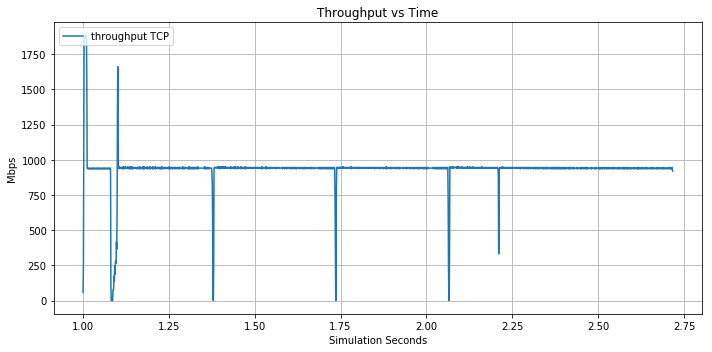

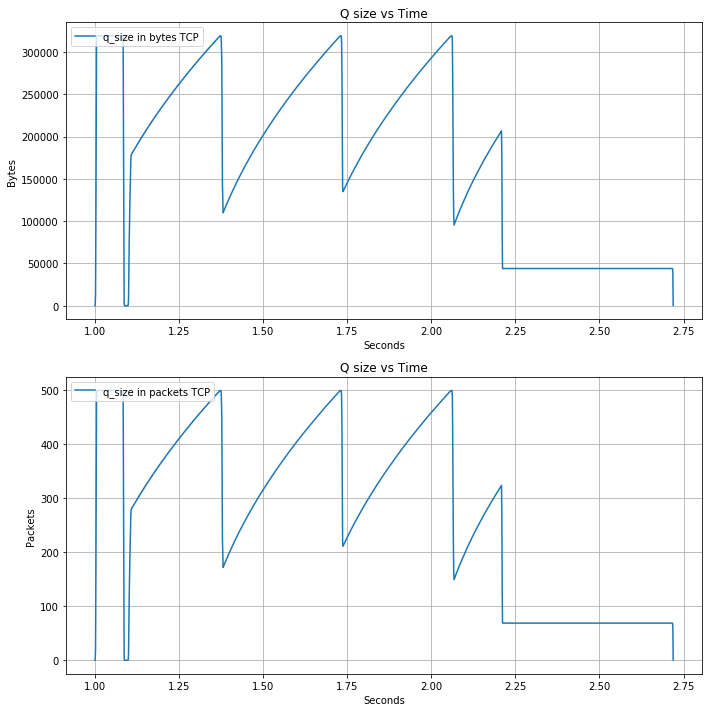

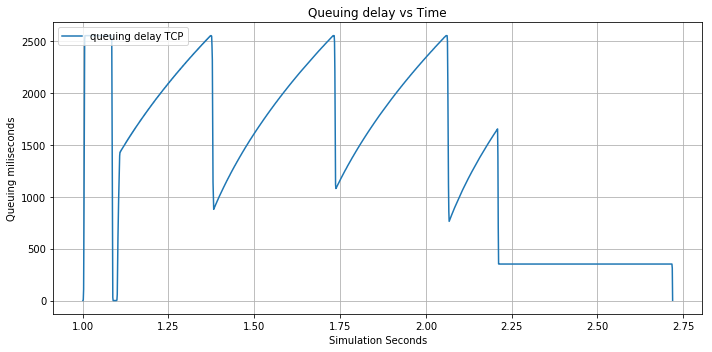

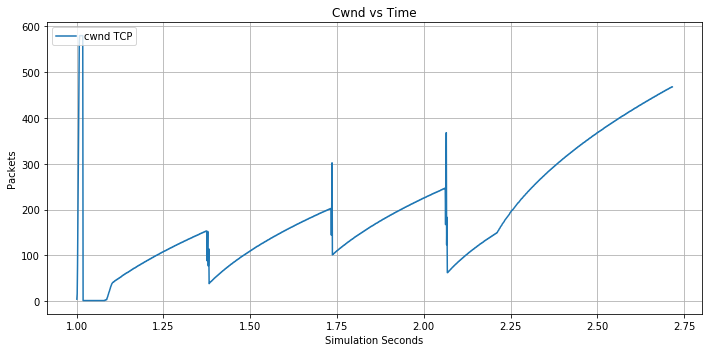

In [277]:
label = "TCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)
print_results()

thrpt_list[0] = thrpt_mean
delay_mean_list[0] = delay_mean
delay_99_list[0] = delay_99


# DCTCP - 30K

Mean Q length in Kbytes 13.503821570588322 and in packets 21.099736701120282
    99th percentile in Kbytes 15.875398644684296 and in packets 24.805310382319213

Mean delay in us 108.03057256470657 and 99th percentile delay in us 127.00318915747437
Mean thrpt in Mbps 935.6725146198831 and 99th percentile thrpt in Mbps 960.0


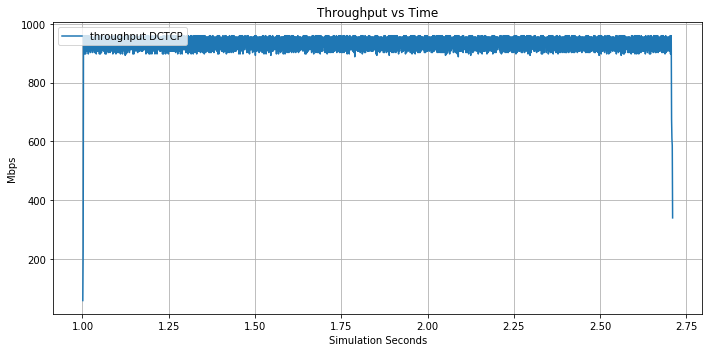

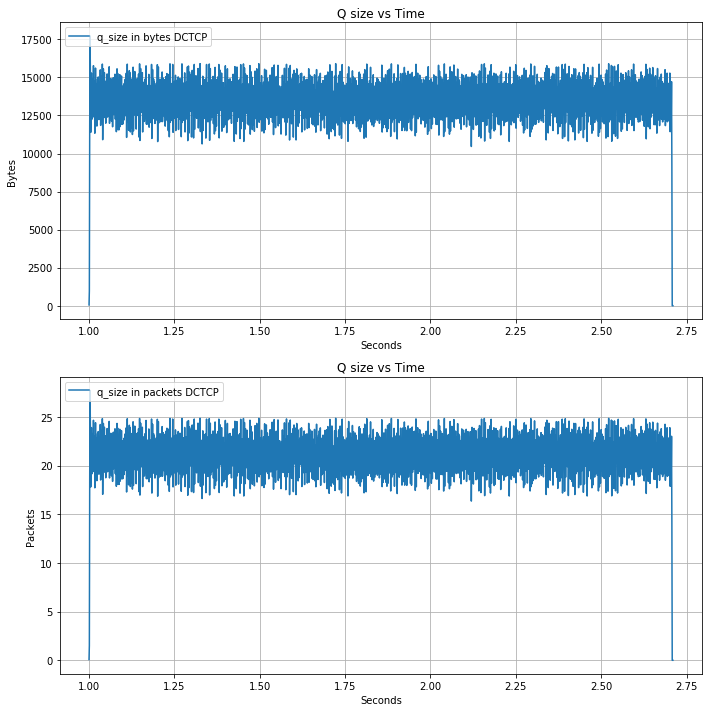

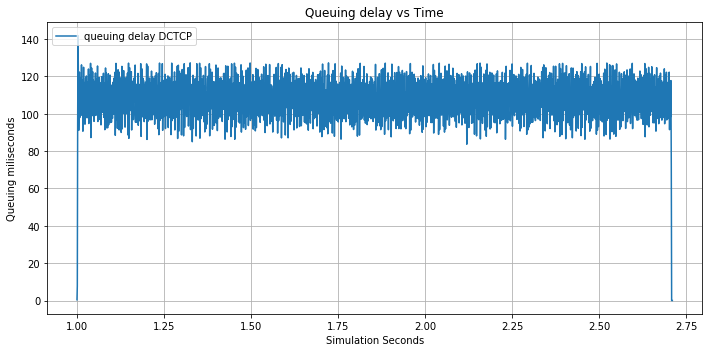

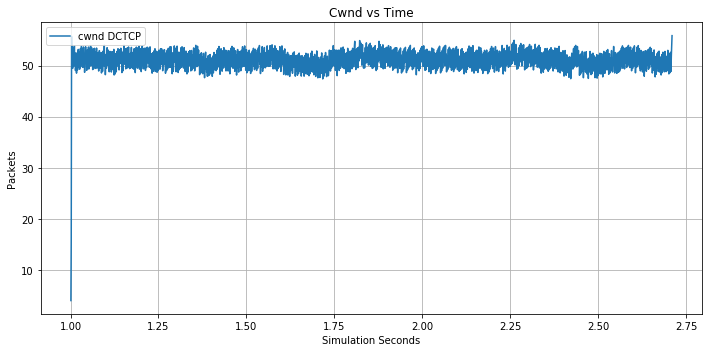

In [276]:
label = "DCTCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[1] = thrpt_mean
delay_mean_list[1] = delay_mean
delay_99_list[1] = delay_99

# DCTCP - 6K + Pacing

Mean Q length in Kbytes 2.11851295422776 and in packets 3.3101817036126686
    99th percentile in Kbytes 3.1191836583566093 and in packets 4.873724466182202

Mean delay in us 16.94810363382208 and 99th percentile delay in us 24.953469266852874
Mean thrpt in Mbps 931.8578916715201 and 99th percentile thrpt in Mbps 964.8


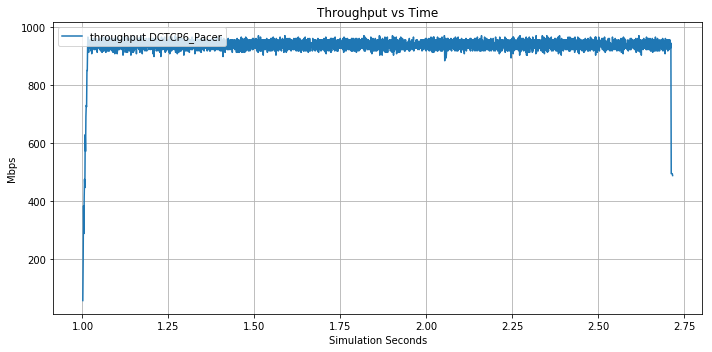

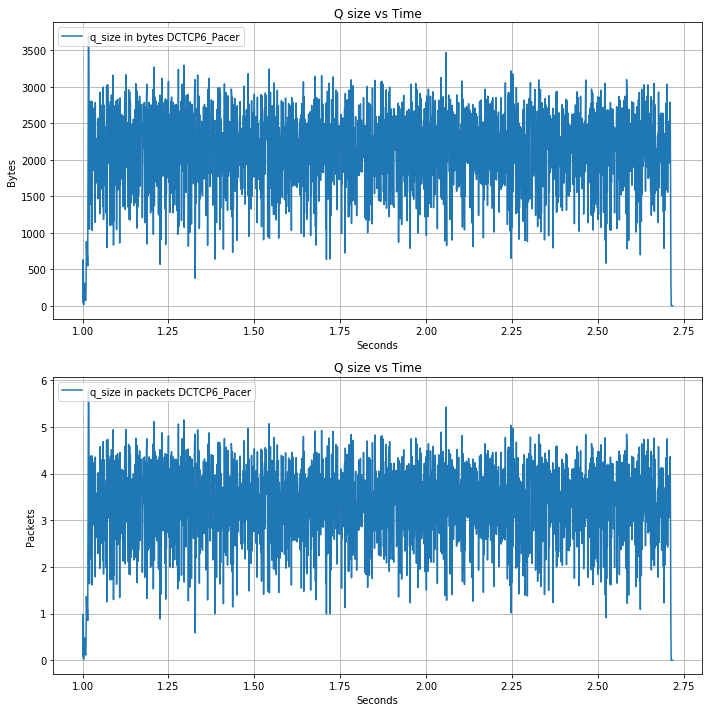

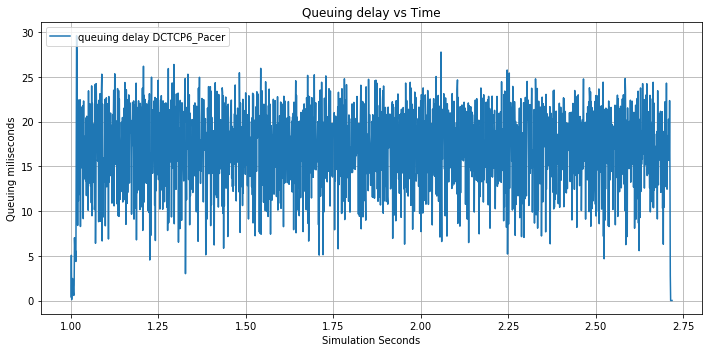

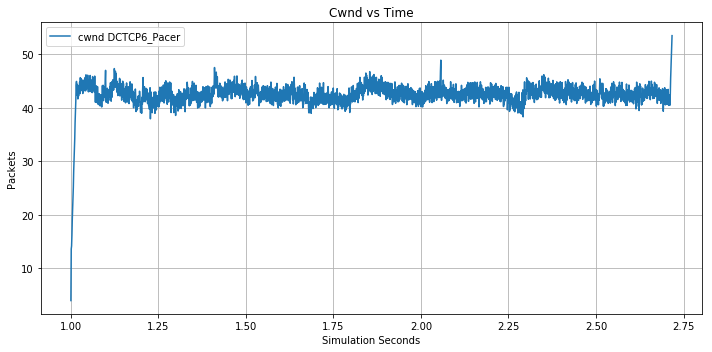

In [275]:
label = "DCTCP6_Pacer"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[2] = thrpt_mean
delay_mean_list[2] = delay_mean
delay_99_list[2] = delay_99

# DCTCP + PQ950 + Pacing

Mean Q length in Kbytes 0.22967553392231846 and in packets 0.35886960718879235
    99th percentile in Kbytes 0.4056797399119645 and in packets 0.6338745936124445

Mean delay in us 1.8374042713785477 and 99th percentile delay in us 3.245437919295716
Mean thrpt in Mbps 717.649697241534 and 99th percentile thrpt in Mbps 777.6


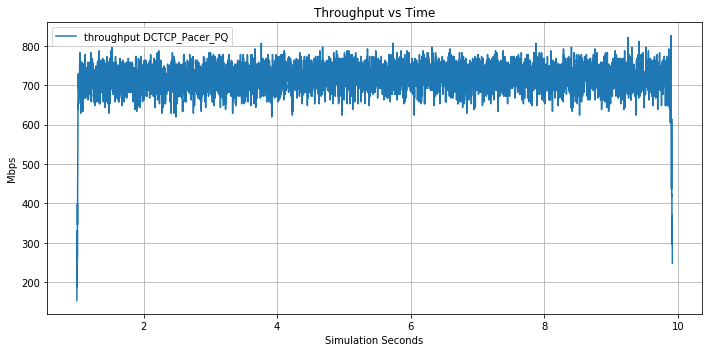

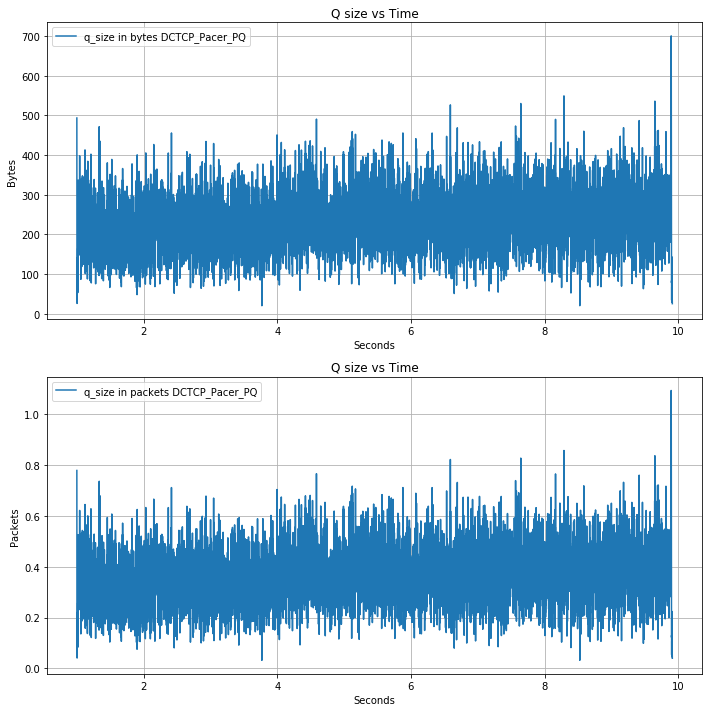

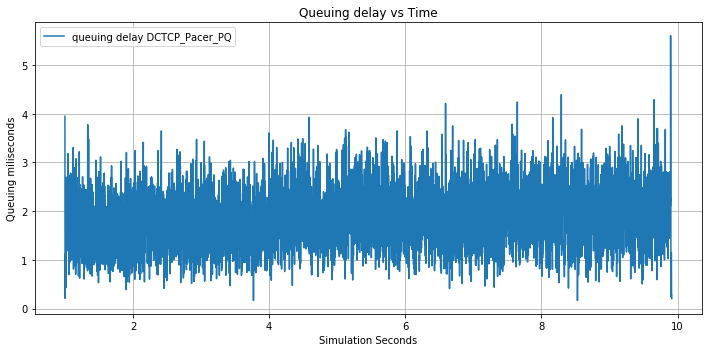

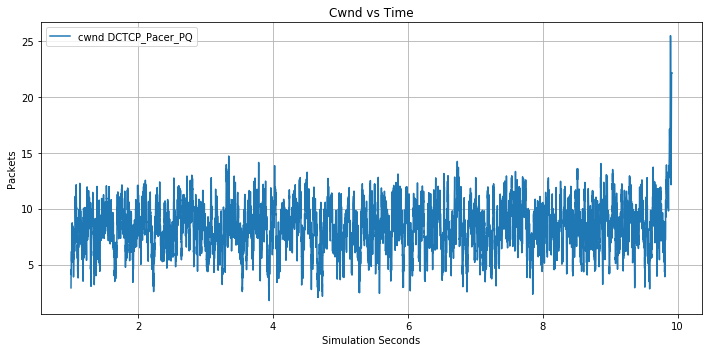

In [278]:
label = "DCTCP_Pacer_PQ"
q_mon = np.genfromtxt("q_mon|"+label+"|8", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|8", delimiter=",")
thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[3] = thrpt_mean
delay_mean_list[3] = delay_mean
delay_99_list[3] = delay_99

# AGGREAGTES

In [268]:
print(delay_mean_list)
print(delay_99_list)
print(thrpt_list)

[1024.9020478043183, 120.40387585711775, 27.950942809454034, 17.47237448665075]
[2554.720255999641, 122.74760499161347, 30.085860038114816, 163.57135846371168]
[754.436911487759, 937.3169302870533, 936.2200117027502, 591.0602142593277]


In [269]:
nums_flows = [2,3,4,5,6,7,8]
labels = ["TCP","DCTCP","DCTCP6_Pacer","DCTCP_Pacer_PQ"]
delay_results = np.zeros(shape=(len(labels), len(nums_flows)))
delay_results_99 = np.zeros(shape=(len(labels), len(nums_flows)))
throughput_results = np.zeros(shape=(len(labels), len(nums_flows)))

for col,num_flows in enumerate(nums_flows):
    for row,label in enumerate(labels):
        file_suffix = label+"|"+str(num_flows)
        print(file_suffix)
        q_mon = np.genfromtxt("q_mon|"+file_suffix, delimiter=" ")
        thrpts =np.genfromtxt("thrpt_mon|"+file_suffix, delimiter=",")

        thrpt_mean, thrpt_99 = plot_througput(thrpts, label, do_plot=False)
        delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1, do_plot=False)
        
        delay_results[row,col] = delay_mean
        delay_results_99[row,col] = delay_99
        throughput_results[row,col] = thrpt_mean

print(delay_results)
print(delay_results_99)
print(throughput_results)

TCP|2
DCTCP|2
DCTCP6_Pacer|2
DCTCP_Pacer_PQ|2
TCP|3
DCTCP|3
DCTCP6_Pacer|3
DCTCP_Pacer_PQ|3
TCP|4
DCTCP|4
DCTCP6_Pacer|4
DCTCP_Pacer_PQ|4
TCP|5
DCTCP|5
DCTCP6_Pacer|5
DCTCP_Pacer_PQ|5
TCP|6
DCTCP|6
DCTCP6_Pacer|6
DCTCP_Pacer_PQ|6
TCP|7
DCTCP|7
DCTCP6_Pacer|7
DCTCP_Pacer_PQ|7
TCP|8
DCTCP|8
DCTCP6_Pacer|8
DCTCP_Pacer_PQ|8
[[1.40143378e+03 1.83980484e+03 1.85779255e+03 1.88503145e+03
  1.90070357e+03 1.91221874e+03 1.92099168e+03]
 [1.08030573e+02 1.08712179e+02 1.11245660e+02 1.12564519e+02
  1.13263244e+02 1.13714154e+02 1.13654837e+02]
 [1.69481036e+01 1.69979936e+01 1.71843940e+01 1.78219602e+01
  1.84183034e+01 1.87407286e+01 1.90708143e+01]
 [1.15969476e+00 1.39517847e+00 1.45208140e+00 1.58735975e+00
  1.71227927e+00 1.82939046e+00 1.83740427e+00]]
[[2.55360205e+03 2.55359671e+03 2.55360123e+03 2.55360205e+03
  2.55360205e+03 2.55360205e+03 2.55360205e+03]
 [1.27003189e+02 1.28905880e+02 1.30658058e+02 1.32506354e+02
  1.34436209e+02 1.36531329e+02 1.38223944e+02]
 [2.49534693e+01 

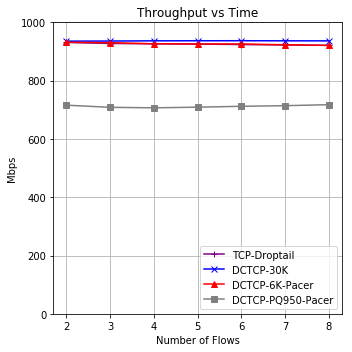

In [270]:

plot_labels = ["TCP-Droptail", "DCTCP-30K", "DCTCP-6K-Pacer", "DCTCP-PQ950-Pacer"]
markers = ["+","x","^","s"]
colors = ["purple", "blue", "red", "gray"]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
for i,lbel in enumerate(plot_labels):
    ax1.plot(nums_flows, throughput_results[i,:], label=lbel, marker=markers[i], color=colors[i]) 
ax1.set_title("Throughput vs Time")
ax1.legend(loc='lower right')
ax1.set_ylabel('Mbps')
ax1.set_xlabel('Number of Flows')
ax1.grid(which='major', linestyle="-")
ax1.grid(which='minor', linestyle='--')
ax1.set_ylim(bottom=0, top=1000)

fig.tight_layout()   

fig.savefig("throughput final.png", format="png")
fig.show()

In [271]:
def plot_delays(x,y,yerr=None):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    #ax1.plot(x, y, label="Delay") 
    
    for i,lbel in enumerate(plot_labels):
        filler = np.zeros(shape=(yerr.shape[1],1))
        yerr_tmp = yerr[i,:] - y[i,:]
        yerr_tmp=np.concatenate((filler, yerr_tmp.reshape(yerr.shape[1],1)), axis=1).T
#         print(y[i,:])
#         print(yerr_tmp)
#         print("-----------------")
        ax1.errorbar(x, y[i,:], yerr=yerr_tmp, fmt='none', capsize=2, color = colors[i])
        ax1.semilogy(x, y[i,:], label=lbel, marker=markers[i], color = colors[i])
    ax1.set_title("Delay vs Time")
    ax1.legend(loc='lower right')
    
    ax1.set_ylabel('us')
    ax1.set_xlabel('Number of Flows')
    ax1.grid(which='major', linestyle="-")
    ax1.grid(which='minor', linestyle='--')

    fig.tight_layout()  
    fig.show()

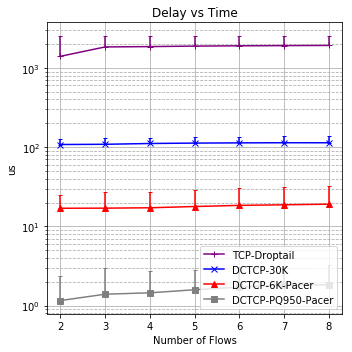

In [272]:
plot_delays(nums_flows, delay_results, delay_results_99)

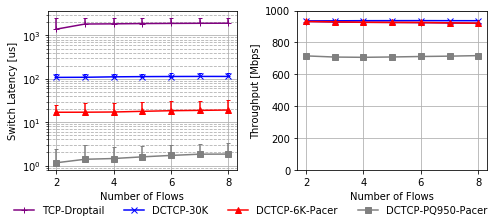

In [273]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
#ax1.plot(x, y, label="Delay") 

for i,lbel in enumerate(plot_labels):
    filler = np.zeros(shape=(delay_results_99.shape[1],1))
    yerr_tmp = delay_results_99[i,:] - delay_results[i,:]
    yerr_tmp=np.concatenate((filler, yerr_tmp.reshape(delay_results_99.shape[1],1)), axis=1).T
    ax1.errorbar(nums_flows, delay_results[i,:], yerr=yerr_tmp, fmt='none', capsize=2, color = colors[i])
    ax1.semilogy(nums_flows, delay_results[i,:], label=lbel, marker=markers[i], color = colors[i])
#ax1.set_title("Switch Latency")
#ax1.legend(loc='lower right')

ax1.set_ylabel('Switch Latency [us]')
ax1.set_xlabel('Number of Flows')
ax1.grid(which='major', linestyle="-")
ax1.grid(which='minor', linestyle='--')

for i,lbel in enumerate(plot_labels):
    ax2.plot(nums_flows, throughput_results[i,:], label=lbel, marker=markers[i], color=colors[i]) 
#ax2.set_title("Aggregate Throughput")
#ax2.legend(loc='lower right')
ax2.set_ylabel('Throughput [Mbps]')
ax2.set_xlabel('Number of Flows')
ax2.grid(which='major', linestyle="-")
ax2.grid(which='minor', linestyle='--')
ax2.set_ylim(bottom=0, top=1000)

handles, labels = ax2.get_legend_handles_labels()

fig.legend(handles, labels, loc= (0.02,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
fig.tight_layout()  
fig.show()